In [2]:
import pickle 
import torch as th
from torch_geometric.explain import Explainer, CaptumExplainer
import torch.nn.functional as F
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
with open('interm/BoT-IoT_reduced_graph.pkl', 'rb') as f:
    G = pickle.load(f)

/home/taznk/COMP4003/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/taznk/COMP4003/venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`

In [4]:
G_line = G.line_graph(shared=True)

In [5]:
G_line.number_of_nodes(), G_line.number_of_edges()

(148792, 134710628)

In [ ]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import from_dgl
import numpy as np 

# train mask
pyG_line = from_dgl(G_line)
nodes = G_line.number_of_nodes()
train_amount = int(0.8*G_line.number_of_nodes())
pyG_line.train_mask = torch.BoolTensor([False] * nodes)
pyG_line.train_mask[:train_amount] = True
pyG_line.test_mask = ~np.array(pyG_line.train_mask, dtype=bool)

loader = NeighborLoader(
    pyG_line,
    num_neighbors=[10] * 3,
    batch_size=128,
    shuffle=True,
    num_workers=6,
    input_nodes=pyG_line.train_mask
)

# !!! more samples ??
test_loader = NeighborLoader(
    pyG_line,
    num_neighbors=[10] * 3,
    batch_size=128,
    shuffle=True,
    num_workers=6,
    input_nodes=pyG_line.test_mask
)

batch = next(iter(loader))
print(batch)

/tmp/ipykernel_152691/1449081621.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  pyG_line.test_mask = ~np.array(pyG_line.train_mask, dtype=bool)
/home/taznk/COMP4003/venv/lib/python3.11/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Data(edge_index=[2, 37514], x=[21821, 49], Attack=[21821], train_mask=[21821], test_mask=[21821], n_id=[21821], e_id=[37514], input_id=[128], batch_size=128)


In [16]:
import gc
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.nn.models.basic_gnn import GraphSAGE

g = pyG_line

model = GraphSAGE(
    49,
    hidden_channels=64,
    out_channels=5,
    num_layers=3,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train_epoch(model, train_loader, test_loader):
    total_loss = 0
    for batch in tqdm(train_loader):
        
        optimizer.zero_grad()
        
        batch = batch.to(device)   
        out= model( batch.x.to(device), batch.edge_index.to(device))
        out = out[:batch.batch_size]
        y = batch.Attack[:batch.batch_size]

        loss = F.cross_entropy(out, y)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        
        del batch
        
    total_test_loss = 0
    for batch in tqdm(test_loader):
        model.eval()
        with torch.no_grad():
            out = model(batch.x.to(device), batch.edge_index.to(device))
            out = out[:batch.batch_size]
            y = batch.Attack[:batch.batch_size]
            total_test_loss += F.cross_entropy(out, y)
        
        del batch
        
    return total_loss / 128, total_test_loss / 128

loss, test_loss = train_epoch(model, loader, test_loader)


100%|██████████| 1163/1163 [00:18<00:00, 61.40it/s]


### when using the explainer, will it load in all edges into memory ?? how does the overflow even happen ?? !! what are the  preprocessing steps from the given paper EXACTLY

In [17]:
loss, test_loss

(0.8096078093803953, tensor(0.))

100%|██████████| 1163/1163 [00:16<00:00, 69.48it/s]


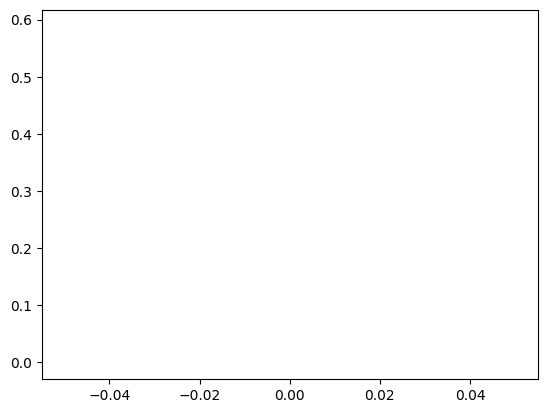

 98%|█████████▊| 1144/1163 [00:18<00:00, 62.06it/s]


KeyboardInterrupt: 

In [19]:
import matplotlib.pyplot as plt
import os

l, tl = [], []
for epoch in range(10):
    loss, test_loss = train_epoch(model, loader, test_loader)
    l.append(loss)
    tl.append(test_loss)
    print(np.array(l).mean(), np.array(tl).mean())
    
plt.plot(l)
plt.plot(tl)
plt.show()